# OMIM phenotypes and inheritance modes of constrained genes
Plot the proportion of genes which are associated with an OMIM morbid phenotype. The plot is stratified by region, constraint, and inheritance pattern. 

Note:
- Where a gene is associated with a phenotype or phenotypes with more than one mode of inheritance, it is double-counted. I.e. it is counted separately in each inheritance group.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%run _color_tools.ipynb

The color palette is saved in the global variable, C
C = color_palette(blue='#0077bb', green='#009988', orange='#ee7733', red='#cc3311', light_blue='#33bbee', pink='#ee3377', grey='#bbbbbb', black='#000000')


## Data formatting
Reformat the OMIM / constraint annotations so that they are more suitable for plotting

In [2]:
# Read data
df = pd.read_csv("../outputs/omim_phenotypes_in_constrained_regions.tsv", sep="\t")

# Individual phenotypes are converted to True (present) or False (absent)
df["phenotype"] = df["phenotype"].fillna(False)
df.loc[df["phenotype"] != False, "phenotype"] = True

# Limit to relevant columns
df = df[["ensg", "region", "constraint", "phenotype", "inheritance"]]

# Drop duplicates
df = df.drop_duplicates()

# Exclude start-proximal regions, which are uninformative
df = df[df["region"] != "start_proximal"]

print("Region value counts:")
print(df.region.value_counts())

Region value counts:
transcript    12676
distal_nmd    12072
nmd_target     9916
long_exon      1963
Name: region, dtype: int64


## Summary statistics
Calculate the summary statistics necessary for the plot.
- The absolute proportion of genes in each constraint category which are in OMIM, with a given inheritance mode.
- The number of genes in each constraint category

### Format data

In [3]:
# Proportion of constrained genes with a phenotype
_a = df.groupby(["constraint", "region"])["phenotype"].value_counts(normalize=True)

# Inheritance mode for genes with a phenotype
_b = df.groupby(["constraint", "region", "phenotype"])["inheritance"].value_counts(
    normalize=True
)

# Get the absolute proportion for each inheritance mode
omim_constraint_inheritance = (_a * _b).dropna().rename("abs_proportion")

# Number of unique genes in each region / constraint category
_c = df.groupby(["region", "constraint"])["ensg"].nunique().rename("n")

# Combine absolute proportions and gene counts
omim_constraint_inheritance = omim_constraint_inheritance.to_frame()  # Allows merging
omim_constraint_inheritance = omim_constraint_inheritance.merge(
    _c, left_index=True, right_index=True
)  # Add gene counts
omim_constraint_inheritance = omim_constraint_inheritance.reset_index(drop=False)

# Order the data
constraint = ["constrained", "unconstrained"]
region = ["transcript","nmd_target","long_exon","distal_nmd"]
inheritance = ["Autosomal dominant","Autosomal recessive","X-linked","Other"]

for col, order in zip(["constraint","region","inheritance"],[constraint,region,inheritance]):
    omim_constraint_inheritance[col] = pd.Categorical(omim_constraint_inheritance[col], categories=order, ordered=True,)

omim_constraint_inheritance = omim_constraint_inheritance.sort_values(["constraint","region","inheritance"], ascending=True)

# Show a sample of the data:
print("Show a sample of the data:")
omim_constraint_inheritance.sample(3)

Show a sample of the data:


,constraint,region,phenotype,inheritance,abs_proportion,n
31,unconstrained,transcript,True,X-linked,0.001109,8880
17,unconstrained,distal_nmd,True,Autosomal dominant,0.059018,11233
28,unconstrained,transcript,True,Autosomal recessive,0.125194,8880


Genes associated with >1 mode of inheritance are double-counted.

### Plot

In [4]:
def plot_omim_constraint_inheritance(df, ax, region, legend=False, ylabel=False):

    df = df.query(f"region == '{region}'")

    colors = {
        "Autosomal dominant": C.blue,
        "Autosomal recessive": adjust_lightness(C.blue, 1.5),
        "X-linked": adjust_lightness(C.green, 1),
        "Other": adjust_lightness(C.grey, 1),
    }

    labels = {
        "transcript": "Transcript",
        "nmd_target": "NMD Target",
        "long_exon": "Long Exon",
        "distal_nmd": "Distal",
    }

    # Define common variables
    inheritance = df.inheritance.unique()
    n = df["constraint"].nunique()
    ticks = np.arange(n)

    # A stacked bar chart - define the y-axis coordinate of the bottom of the bar
    bottom = np.zeros(len(ticks))

    # For each inheritance mode, add a separate bar to the Axes
    for i in inheritance:

        color = colors[i]

        # Subset to one inheritance mode
        _df = df[df["inheritance"] == i]

        # Add the bar(s)
        b = ax.bar(
            x=ticks,
            height=_df["abs_proportion"],
            label=_df["inheritance"],
            color=color,
            bottom=bottom,  # The y-position of the bottom of the bar
        )

        # Stack the bars
        bottom += list(_df["abs_proportion"])
        
    # Y label
    
    if ylabel: 
        ax.set_ylabel(ylabel)
    
    # Y ticks    
    ax.set_yticks(ticks=[0, 0.1, 0.2, 0.3])

    # X ticks
    ax.set_xticks(
        ticks=ticks,
        labels=_df["constraint"].str.capitalize(),
        rotation=90,
        # rotation_mode="anchor",
        # ha="right"
    )
    
    ax.tick_params(axis="x", length=0)  # Hide x ticks
    
    # Title
    ax.set_title(labels[region])

    # Legend
    if legend:
        handles = [ax.get_legend_handles_labels()[0][x] for x in [0,2,4,6]][::-1]
        labels = [ax.get_legend_handles_labels()[1][x] for x in [0,2,4,6]][::-1]
        ax.legend(handles, labels, bbox_to_anchor=(1, 0), loc="lower left")

    return ax.get_legend_handles_labels()

In [5]:
cm = 1 / 2.54

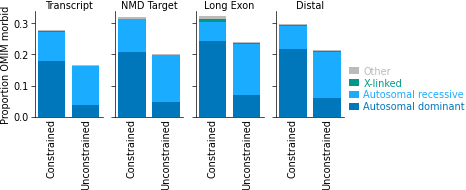

In [6]:
# Specify figure properties
fig, axs = plt.subplots(
    1, 4, layout="constrained", figsize=(12 * cm, 5 * cm), sharey=True,
)

plot_omim_constraint_inheritance(omim_constraint_inheritance, axs[0], "transcript", ylabel="Proportion OMIM morbid")
plot_omim_constraint_inheritance(omim_constraint_inheritance, axs[1], "nmd_target")
plot_omim_constraint_inheritance(omim_constraint_inheritance, axs[2], "long_exon")
plot_omim_constraint_inheritance(omim_constraint_inheritance, axs[3], "distal_nmd", legend=True)

# Save the figure
plt.savefig(
    "../plots/fig_s2_omim_morbid_constrained_regions.svg", format="svg", bbox_inches="tight"
)